<a href="https://colab.research.google.com/github/vidyameidita/crudVidya/blob/main/yt_category_classification_vidya_meidita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=5b2121fb36ed4b0b7f4618823831c1593e4f869c8927444f90f64ffb0bc47fd7
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
from textwrap import wrap
import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

In [ ]:
def get_category_dict(category_file):
  category = pd.read_json(category_file, orient="records")
  category = pd.DataFrame(category["items"].values.tolist())

  return{
      cat.id: cat.snippet.get("title")
      for cat in category.itertuples(index=False)
  }

In [ ]:
category_dict =get_category_dict("/content/drive/MyDrive/Colab Notebooks/category.json")

In [ ]:
trending = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trending.csv", parse_dates=["publish_time", "trending_time"])
with pd.option_context("display.max_columns", None):
  display (trending.head())

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [ ]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date = }")
print (f"{end_date = }")

start_date = '2021-02-07 05:46:51.832614+00:00'
end_date = '2023-09-01 09:16:49.916211+00:00'


In [ ]:
trending['trending_time'] = pd.to_datetime(trending['trending_time'], format='mixed', errors='coerce')
# The 'format='mixed'' argument allows pandas to infer the format for each element individually.
#The 'errors='coerce'' will set invalid values to NaT(Not a time).
filtered_trending = trending[trending.trending_time.dt.month >= 7 ]
start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print (f"{start_date =}")
print (f"{end_date =}")

start_date =Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date =Timestamp('2023-09-01 09:16:49.916211+0000', tz='UTC')


In [ ]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos = }")

num_videos = 81517


In [ ]:
filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81517 entries, 21322 to 172346
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           49717 non-null  object             
 1   publish_time       81517 non-null  datetime64[ns, UTC]
 2   channel_id         81517 non-null  object             
 3   title              81517 non-null  object             
 4   description        78544 non-null  object             
 5   thumbnail_url      49717 non-null  object             
 6   thumbnail_width    49717 non-null  float64            
 7   thumbnail_height   49717 non-null  float64            
 8   channel_name       81517 non-null  object             
 9   tags               70149 non-null  object             
 10  category_id        81517 non-null  int64              
 11  live_status        81517 non-null  object             
 12  local_title        81517 non-null  object     

In [ ]:
filtered_trending.dropna(subset=["description"], inplace=True)

In [ ]:
trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of videos in trending per day:", num_trending_per_day.unique())

Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200 381]


In [ ]:
trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
1,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
3,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
4,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
5,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
8,"HANYA FARIDA NURHAN, MUKBANG MIE GACOAN LEVEL ...",32,2022-07-11 06:00:59.414152+00:00,2022-08-11 06:01:46.801212+00:00
9,BORONG ISI KULKAS SAMA BABY SHARK!!!,32,2022-07-02 06:01:31.621266+00:00,2022-08-02 06:14:40.735514+00:00


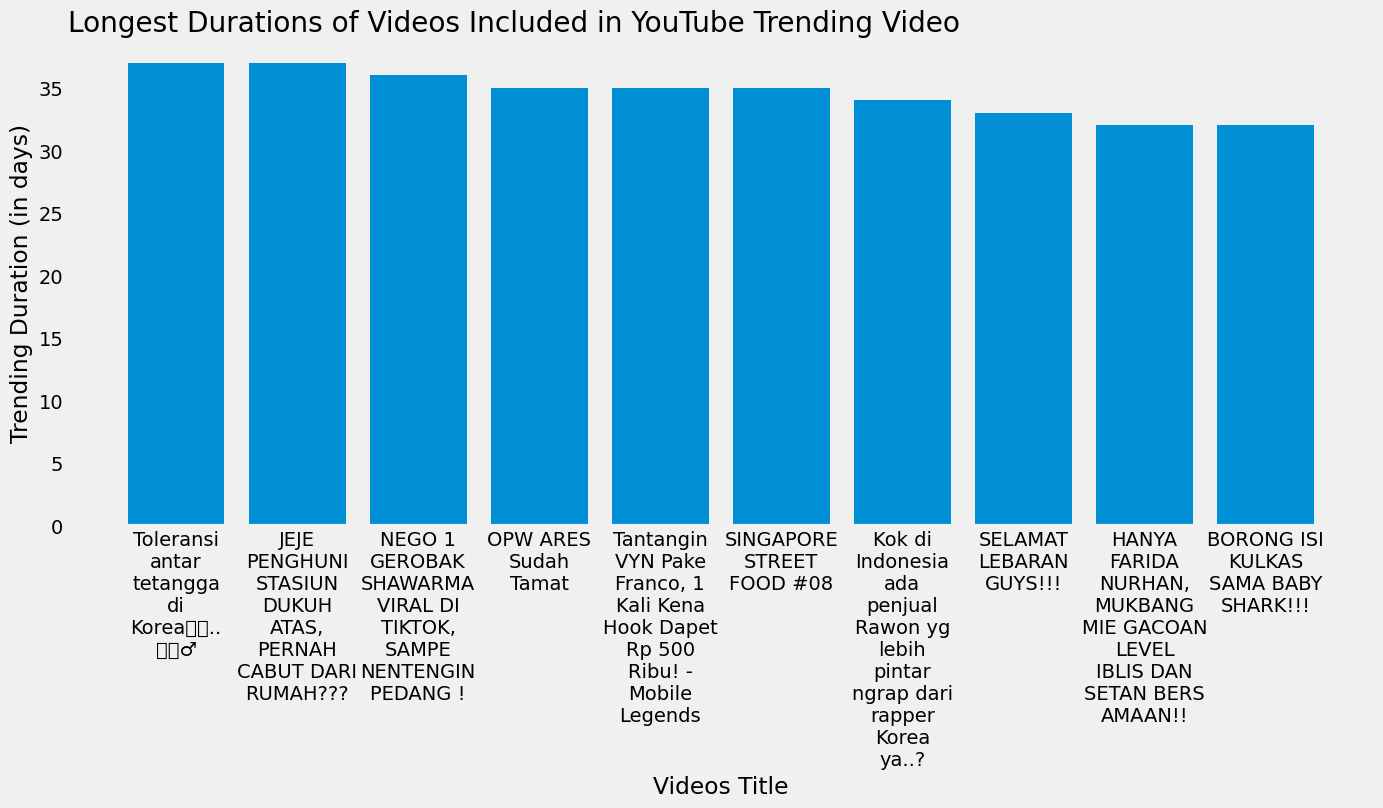

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]
)
plt.title("Longest Durations of Videos Included in YouTube Trending Video", loc="left")
plt.xlabel("Videos Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

In [ ]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max","mean","sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1798947.0  2064042.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1.981122e+06  19811225.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         41528.0   44699.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         43795.800000   437958.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

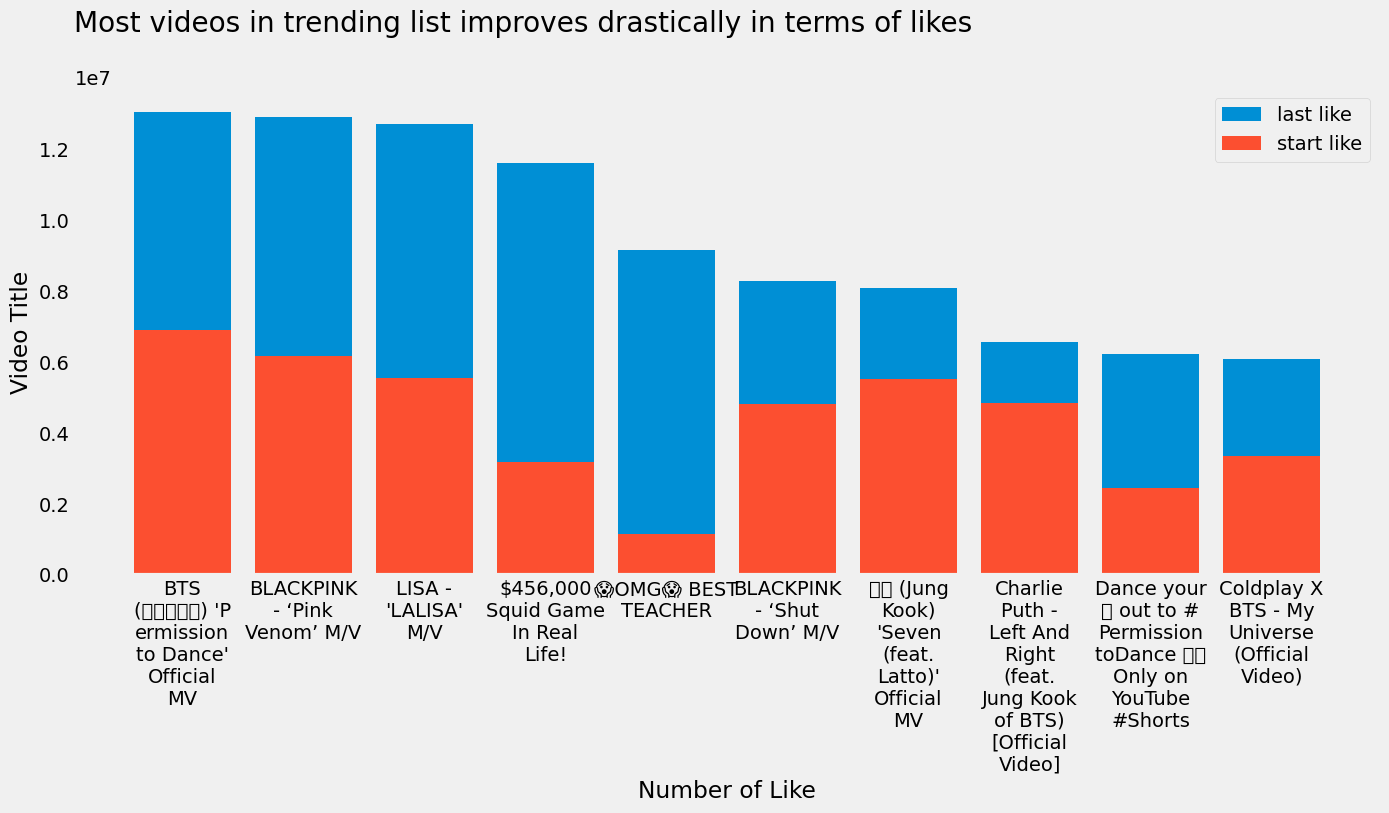

In [ ]:
top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15,6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="last like"
)
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="start like"

)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

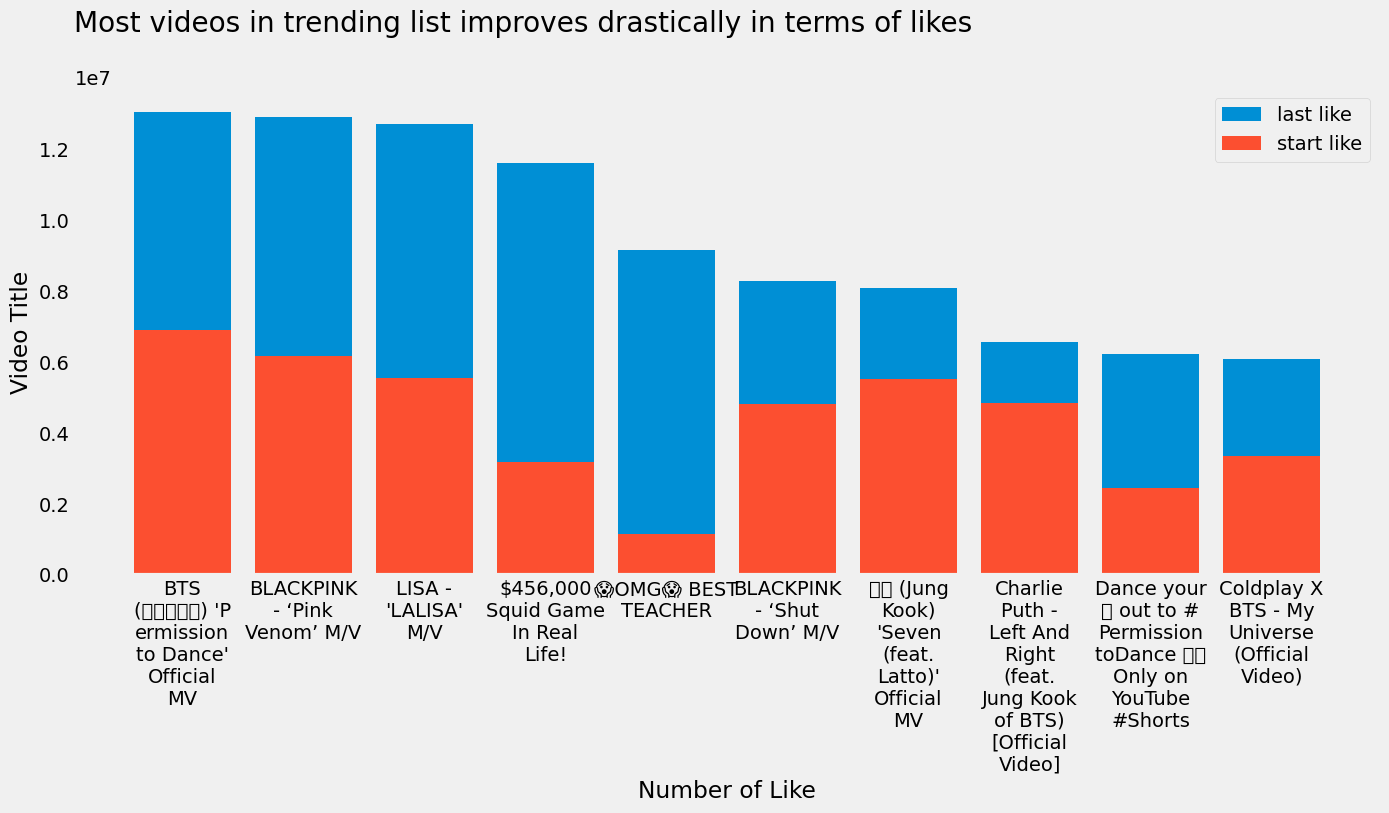

In [ ]:
top_10_viewed = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15,6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="last like"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="start like"

)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

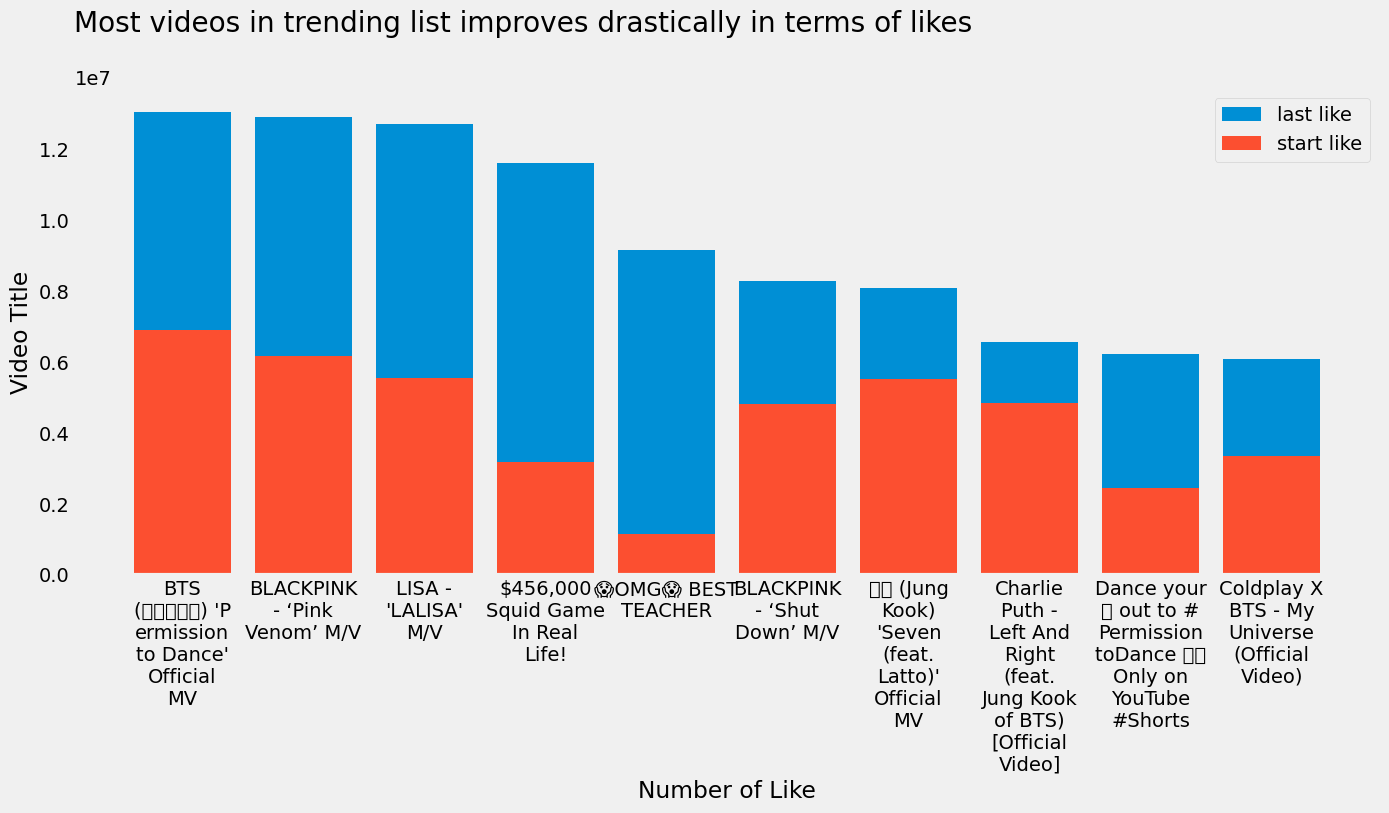

In [ ]:
top_10_disliked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15,6))
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="last like"
)
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["min"],
    label="start like"

)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineCha...,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSpon...
109477,The Pangeran and Justin Show: Badmin Son Hat-t...,Son Heung-min bikin langsung bikin hattrick se...
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 1...,PERSIB meraih kemenangan 3-0 atas Persik Kedir...
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG...,Galeri 19 | Part 7\n==========================...
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ri...,(COVER)Andekhi Anjaani - Putri Isnari feat Rid...
95923,Mira Putri ft Ageng Music - TIARA (Official Li...,Official Live Music : Mira Putri ft Ageng Musi...
121702,JKT48 New Era Special Performance Video – Eure...,Eureka Milik Kita hadir dengan konsep yang ber...
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR ...,#rachelvennya #covid #podcast
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,Silakan komen di bawah 🖤 Kalian mau aku buat k...
46159,Yeni Inka - Top Topan (Official Music Video AN...,Title: Top Topan\nArtist: Yeni Inka\nSongwrite...


In [ ]:
sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [ ]:
with pd.option_context("display.max_colwidth", 100):
  display(sample[["title", "title_lang", "description","desc_lang"]])

,title,title_lang,description,desc_lang
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineChallenge (2/8),tl,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSponsored by MS Slim by Ms Glow\n\nCHALLENGE FOOD VLOG...,en
109477,"The Pangeran and Justin Show: Badmin Son Hat-trick, Koci Gak Terkesan!",en,Son Heung-min bikin langsung bikin hattrick setelah gak mencetak gol di 8 pertandingan. Tapi Coa...,id
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 12 Liga 1 2022,id,"PERSIB meraih kemenangan 3-0 atas Persik Kediri pada pekan ke-12 Liga 1 di Stadion Manajan, Solo...",id
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG DIPANGGIL LORD ADI PANIK LAH MASA ENGGAK! | Galer...,id,Galeri 19 | Part 7\n=======================================\nPANIK GAK? PANIK GAK? PANIKLAH MASA...,id
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ridwan,id,"(COVER)Andekhi Anjaani - Putri Isnari feat Ridwan\n\nDalam proses pembuatan video ini, seluruh t...",id
95923,Mira Putri ft Ageng Music - TIARA (Official Live Music) Jika kau bertemu aku begini,id,Official Live Music : Mira Putri ft Ageng Music - Tiara\nSubscribe Global Musik Era Digital\nhtt...,id
121702,JKT48 New Era Special Performance Video – Eureka Milik Kita,da,Eureka Milik Kita hadir dengan konsep yang berbeda! Kali ini JKT48 Zee berkolaborasi dengan para...,en
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR COBA‼️ Prof ZUBAIRI - dr TIRTA - Corbuzier Podcast,id,#rachelvennya #covid #podcast,en
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,id,Silakan komen di bawah 🖤 Kalian mau aku buat konten apa lagi?\n\nTHANKYOU FOR 🤍\n\n- WO : @savet...,en
46159,Yeni Inka - Top Topan (Official Music Video ANEKA SAFARI) Kulo pun angkat tangan | MIQBAL GA,tl,Title: Top Topan\nArtist: Yeni Inka\nSongwriter: MIQBAL GA\n\nFollow juga kita disini yuk :\nTik...,id


In [ ]:
def detect_language(text):
    """Detect language of the 'text'. """
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return  # atau nilai lain sesuai kebutuhan


In [ ]:
lang_cache = {}

def detect_language_cached(text):
    if text in lang_cache:
        return lang_cache[text]
    try:
        lang = langdetect.detect(text)
    except:
        lang = None
    lang_cache[text] = lang
    return lang

filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language_cached)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language_cached)


In [ ]:
filtered_trending[["title","title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
172342,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,so,#sule #njan #inibukantalkshow #rizkyfebian #pu...,id
172343,Sangkolan 1 | short movie madura ( SUB INDONES...,id,Welcome to @Akeloy Production \nKali ini kami...,id
172344,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,de,#desa #pulangkampung #yennydichina #indonesi...,id
172345,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,id,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",id


In [ ]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")

]

with pd.option_context("display.max_columns", None):
  display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
108996,EIXJtfryK1s,2022-09-27 14:00:14+00:00,UCKFC1LYWw1fbe9LNfm2vEPg,JURNALRISA - MEMASAK NASI BITTERBALLEN BERSAMA...,"Selamat datang di #jurnalrisa,\nSiapa nih yang...",https://i.ytimg.com/vi/EIXJtfryK1s/hqdefault.jpg,480.0,360.0,Jurnal Risa,"['jurnalrisa', 'risa saraswati', 'danur', 'asi...",22,none,JURNALRISA - MEMASAK NASI BITTERBALLEN BERSAMA...,"Selamat datang di #jurnalrisa,\nSiapa nih yang...",PT30M23S,2d,hd,True,True,NaN,NaN,671028.0,61243.0,NaN,0,2538.0,2022-10-02 06:01:28.837606+00:00,en,id
124652,yHQaqC9e3gs,2022-12-13 12:00:35+00:00,UC3yFi2eTanFWEE3_ln3XoaQ,SEKARANG SAYA MENGERTI KENAPA NAMANYA SOTO KAMPUS,Mamen bareng gw lagi di Aslinya kuliner lokal ...,https://i.ytimg.com/vi/yHQaqC9e3gs/hqdefault.jpg,480.0,360.0,Nex Carlos,"['rumah makan', 'review makanan', 'makan kelil...",22,none,SEKARANG SAYA MENGERTI KENAPA NAMANYA SOTO KAMPUS,Mamen bareng gw lagi di Aslinya kuliner lokal ...,PT9M44S,2d,hd,False,True,NaN,NaN,576059.0,10913.0,NaN,0,416.0,2022-12-20 06:00:50.324138+00:00,de,id
100094,htfHmOZoAcg,2022-08-05 00:00:11+00:00,UCJhYZjeQG25rDmevmy4szMw,James AP Ft. Fida - Tepung Kanji (Live Version),Tepung Kanji ft. Fida (live version)\n\n\n\nVi...,https://i.ytimg.com/vi/htfHmOZoAcg/hqdefault.jpg,480.0,360.0,James AP,"['Fida', 'James AP', 'Tepung Kanji']",10,none,James AP Ft. Fida - Tepung Kanji (Live Version),Tepung Kanji ft. Fida (live version)\n\n\n\nVi...,PT5M32S,2d,hd,False,True,NaN,NaN,943004.0,23365.0,NaN,0,1806.0,2022-08-18 06:01:21.547332+00:00,de,id
41289,NaN,2021-10-06 08:00:53+00:00,UCvp0CPEB3M-iCkmT5RHYh7Q,AESPA 'SAVAGE' MV REACTION,Teori apa lagi ini?!\n\nNih kalo ada yang mau ...,NaN,NaN,NaN,Alphiandi,"['alphiandi', 'kocak', 'jenis jenis kpopers ba...",22,none,AESPA 'SAVAGE' MV REACTION,Teori apa lagi ini?!\n\nNih kalo ada yang mau ...,PT7M59S,2d,hd,False,False,NaN,NaN,95589.0,9983.0,83.0,0,552.0,2021-10-08 06:00:58.292858+00:00,en,id
124365,qL2uL8QRDQc,2022-12-17 18:30:44+00:00,UCdmIbbRekb8q05LV9ZejzsA,Croatia vs. Morocco - Game Highlights,Saksikan cuplikan lengkap dan pertandingan Pia...,https://i.ytimg.com/vi/qL2uL8QRDQc/hqdefault.jpg,480.0,360.0,Vidio,"['piala dunia', 'world cup', 'croatia', 'kroas...",17,none,Croatia vs. Morocco - Game Highlights,Saksikan cuplikan lengkap dan pertandingan Pia...,PT1M19S,2d,hd,False,True,['ID'],NaN,903617.0,3095.0,NaN,0,921.0,2022-12-19 06:00:46.149490+00:00,en,id
99504,p8y3b2hAXxY,2022-07-28 17:00:35+00:00,UChDuhCkrQ8IhdzSh2X7CkWg,Ziva Magnolya - Pilihan Yang Terbaik (Official...,Ziva Magnolya’s official lyric video for singl...,https://i.ytimg.com/vi/p8y3b2hAXxY/hqdefault.jpg,480.0,360.0,ZivaMagnolyaVEVO,"['Ziva', 'Magnolya', 'Pilihan', 'Yang', 'Terba...",10,none,Ziva Magnolya - Pilihan Yang Terbaik (Official...,Ziva Magnolya’s official lyric video for singl...,PT3M55S,2d,hd,True,True,NaN,"['BY', 'CA', 'IO', 'KP', 'RU', 'SS', 'US']",3933681.0,105633.0,NaN,0,9220.0,2022-08-15 06:01:33.243241+00:00,tl,id
41971,NaN,2021-10-06 23:00:07+00:00,UC24_Z2L-8Ki183AI9zJJzNQ,Surprise! Desta Gak Nyangka ENZY STORIA Datang...,"LAPOR PAK!\nRabu, 6 Oktober 2021\n\nPART 1 : h...",NaN,NaN,NaN,TRANS7 OFFICIAL,"['TRANS7', 'TRANSMEDIA', 'TRANS7 LIVESTREAMING...",24,none,Surprise! Desta Gak Nyangka ENZY STORIA Datang...,"LAPOR PAK!\nRabu, 6 Oktober 2021\n\nPART 1 : h...",PT11M30S,2d,hd,False,True,NaN,NaN,3505269.0,65558.0,1159.0,0,3905.0,2021-10-12 06:00:55.408890+00:00,id,id
170115,Wt0S0YVMncU,2023-08-07 07:32:56+00:00,UCfZNq8mYot3GwCmJitQxL4g,"SETELAH EMPAT TAHUN TERPISAH, BERKUMPUL LAGI B...",#pulangkampung #kumpulkeluarga #desaindonesi...,https://i.ytimg.com/vi/Wt0S0YVMncU/hqdefault.jpg,480.0,360.0,YENNY DI CHINA,NaN,22,none,"SETELAH EMPAT TAHUN TERPISAH, BERKU

In [ ]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
49038,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,#sule #njan #inibukantalkshow #rizkyfebian #pu...,24
49039,Sangkolan 1 | short movie madura ( SUB INDONES...,Welcome to @Akeloy Production \nKali ini kami...,24
49040,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,#desa #pulangkampung #yennydichina #indonesi...,22
49041,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",10


In [ ]:
data.drop_duplicates(subset="title", inplace=True)

In [ ]:
data.reset_index(drop=True, inplace=True)
data.shape

(7294, 3)

In [ ]:
list_emoji = list(emoji.EMOJI_DATA.keys())

count = 0
for em in list_emoji:
    for title in data.title:
        if em in title:
            count += 1
print("How many title use emoji?", count)


How many title use emoji? 986


In [ ]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, em_text)
    return text

In [ ]:
data["title_emoji"] = data.title.apply(demojize)

In [ ]:
title_with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [ ]:
with pd.option_context("display.max_colwidth", 100):
  display(data.loc[title_with_emoji_idx])

,title,description,category_id,title_emoji
33,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤,Saksikan #DariJendelaSMP Setiap Hari Pkl. 16.40 WIB hanya di @Surya Citra Televisi (SCTV) \n@sin...,24,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....
77,BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik,Aksi heroik driver muda membantu sopir minibus yang kesulitan di Sitinjau Lauik\n\ninstagram : h...,2,BIKIN CEWEK TERPESONA :smiling_face_with_heart-eyes: Aksi Heroik Driver Muda Menolong Sopir Yang...
79,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅,"15 menit membakar lemak, ok ! siapa yg workout mengharapkan bisa membakar 1 kg lemak dalam 15 me...",26,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN :check_mark_button: :check_mark_button: ...
144,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY:double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
144,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY:double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
...,...,...,...,...
7275,STANDUPFEST 2023 Extended Version dari The Founders 🥳🥳 - Lucu Terus Nih,"Host yang ada di video ini, Arie Kriting, mau bikin special show! Judulnya ILMU HITAM! Beli tike...",22,STANDUPFEST 2023 Extended Version dari The Founders :partying_face::partying_face: - Lucu Terus Nih
7276,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU?😝,"Hai guys... welcome back in my youtube channel, kali ini aku mau ngajakin ngobrol BOY WILLIAM ni...",22,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU?:squinting_face_with_tongue:
7278,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!?:winking_face:NGOBROL TENTANG GOSIP:Indonesia: SAMBIL MAKAN NASI PADANG SAMA KAK H...
7278,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!?:winking_face:NGOBROL TENTANG GOSIP:Indonesia: SAMBIL MAKAN NASI PADANG SAMA KAK H...


In [ ]:
data.drop(columns="title",inplace=True)

In [ ]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)
with pd.option_context("display.max_colwidth", 100):
  display(data.loc[desc_with_emoji_idx])

,description,category_id,title_emoji,desc_emoji
0,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...,10,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...
10,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...",10,Rey Mbayang - Sempurnakan Hariku (Official Music Video),"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
11,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
11,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
13,#ByoodeJanganCobaCoba #Byoode #MusicVideo #Girlband #Dangdut\n\nDengerin lagu Byoode - Jangan Co...,10,Byoode - Jangan Coba Coba | Official Music Video,#ByoodeJanganCobaCoba #Byoode #MusicVideo #Girlband #Dangdut\n\nDengerin lagu Byoode - Jangan Co...
...,...,...,...,...
7282,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...,22,PASUKAN SENYAP Terancam PEGATON Ketua Kobra Part 4 - DRAMA ANIMASI,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...
7284,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,TERHARU !!BIRTHDAY PARTY LUNA MAYA,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :righ...
7284,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,TERHARU !!BIRTHDAY PARTY LUNA MAYA,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :righ...
7293,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...,20,Q&A sambil makan PADANG di Pasar Senen ft. Jessica Jane :drooling_face:,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...


In [ ]:
data.drop(columns="description",inplace=True)

In [ ]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(
    data["all_text"], data["category_id"],
    test_size=.2,
    stratify=data["category_id"],
    random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]

print(f"{training_size = }.. {dev_size = }")

vectorizer = TfidfVectorizer(
    min_df=.014,
    max_df=.7,
    ngram_range=(1,1),
)

train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)

train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out() )

training_size = 5835.. dev_size = 1459
Got train tf-idf with shape: (5835, 995)
Got dev tf-idf with shape: (1459, 995)


In [ ]:
with pd.option_context("display.max_columns", 100):
  display(train_tfidf.sample(5))

,00,000,01,02,03,04,06,07,08,09,10,100,11,12,13,14,15,16,17,18,19,1dvz1au,1gxqz9s,1st,20,2020,2021,2022,2023,21,22,23,24,25,26,28,2oukyag,2yfofxp,30,31,3ws0f48,40,45,50,62,abg,about,academy,acara,ada,...,us,user,utama,utm_campaign,utm_medium,utm_source,v7,vallen,via,video,videonya,videos,vidio,viral,vita,vlog,voc,vocal,vs,vt,wa,waktu,warga,watch,watching,web,website,welcome,wes,whatsapp,wib,with,withyoutube,wong,world,woro,www,ya,yaa,yah,yaitu,yang,yen,yeni,yg,you,your,youtu,youtube,yuk
1882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.074331,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.157736,0.0,0.0,0.0,0.0,0.238373,0.0,0.0,0.0,0.000000,0.0,0.000000,0.094486,0.0
5447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.206253,0.0,0.0,0.0,0.0,0.274791,0.0,0.0,0.0,0.0,0.069211,0.0,0.0,0.0,0.000000,0.0,0.000000,0.082302,0.0
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082298,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.642416,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.305840,0.0,0.0,0.0,0.0,0.094808,0.0,0.0,0.0,0.000000,0.0,0.000000,0.338220,0.0
1781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.039925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030438,0.0,0.0,0.181838,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.272074,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.052577,0.0,0.000000,0.300879,0.0
4564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.206676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.091397,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.027085,0.0,0.0,0.0,0.0,0.109150,0.0,0.0,0.0,0.000000,0.0,0.056342,0.097346,0.0


In [ ]:
dict_models = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(random_state=11),
    "random_forest": RandomForestClassifier(random_state=11)
}

In [ ]:
for model in dict_models.values():
    print(f"-- {model.__class__.__name__} --")
    model.fit(train_tfidf, y_train)
    y_pred = model.predict(dev_tfidf)
    print("Report on dev set:", classification_report(y_dev, y_pred), sep="\n")


-- LogisticRegression --
Report on dev set:
              precision    recall  f1-score   support

           1       0.97      0.72      0.83        54
           2       1.00      0.66      0.79        44
          10       0.91      0.93      0.92       268
          15       0.91      0.77      0.83        13
          17       0.88      0.76      0.81        66
          19       1.00      0.62      0.77         8
          20       0.95      0.89      0.92       147
          22       0.77      0.72      0.74       148
          23       0.94      0.65      0.77        48
          24       0.77      0.90      0.83       474
          25       0.82      0.92      0.87       126
          26       0.75      0.32      0.44        19
          27       1.00      0.33      0.50        12
          28       1.00      0.60      0.75        20
          29       1.00      1.00      1.00        12

    accuracy                           0.84      1459
   macro avg       0.91      0.72   

In [ ]:
svm_grid_search = GridSearchCV(
    dict_models["svm"],
    {"C": (10, 1, .1, .05, .01)},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print("Report on train set:",
      classification_report(
          y_train,svm_grid_search.predict(train_tfidf)
      ), sep="\n")
print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")

Report on train set:
              precision    recall  f1-score   support

           1       0.97      0.96      0.97       218
           2       0.99      0.99      0.99       176
          10       0.96      0.99      0.97      1070
          15       0.94      0.96      0.95        53
          17       0.94      0.97      0.96       262
          19       1.00      0.88      0.94        33
          20       0.96      0.98      0.97       586
          22       0.94      0.87      0.90       594
          23       0.98      0.91      0.94       191
          24       0.94      0.94      0.94      1896
          25       0.95      0.98      0.97       504
          26       0.92      0.94      0.93        77
          27       0.98      0.92      0.95        48
          28       1.00      0.95      0.97        80
          29       1.00      0.98      0.99        47

    accuracy                           0.95      5835
   macro avg       0.96      0.95      0.96      5835
weigh

In [ ]:
svm_grid_search.best_params_

{'C': 1}

In [ ]:
random_forest_grid_search = GridSearchCV(
    dict_models["random_forest"],
    {
        "n_estimators": (10, 20, 25, 50, 75, 100, 125),
        "max_depth": (5, 10, 25, 50),
    }
)

random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print("Report on train set:",
      classification_report(
          y_train,
          random_forest_grid_search.predict(train_tfidf)
      ),
      sep="\n"
)
print("Report on dev set:", classification_report(y_dev, random_forest_pred), sep="\n")

Report on train set:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       218
           2       1.00      0.97      0.99       176
          10       1.00      0.99      1.00      1070
          15       1.00      0.98      0.99        53
          17       0.99      0.98      0.99       262
          19       1.00      0.79      0.88        33
          20       1.00      0.99      1.00       586
          22       1.00      0.97      0.98       594
          23       1.00      0.96      0.98       191
          24       0.96      1.00      0.98      1896
          25       1.00      0.99      1.00       504
          26       1.00      0.86      0.92        77
          27       1.00      0.94      0.97        48
          28       1.00      0.99      0.99        80
          29       1.00      1.00      1.00        47

    accuracy                           0.99      5835
   macro avg       1.00      0.96      0.98      5835
weigh

In [ ]:
random_forest_grid_search.best_params_

{'max_depth': 50, 'n_estimators': 125}

In [ ]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(
        min_df=.015,
        max_df=.7,
        ngram_range=(1,1),
    )),
    ("model", RandomForestClassifier(
        max_depth=50,
        n_estimators=75,
        random_state=11
    ))
])

model.fit(X_train, y_train)
pred = model.predict(X_dev)
print("Report on dev set:",
      classification_report(
          y_train,
          model.predict(X_train)
          ),
       sep="\n"
)
print("Report on dev set:",
      classification_report(
          y_dev,
          pred
          ),
       sep="\n"
)

Report on dev set:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       218
           2       1.00      0.97      0.99       176
          10       1.00      1.00      1.00      1070
          15       1.00      0.98      0.99        53
          17       0.98      0.98      0.98       262
          19       1.00      0.76      0.86        33
          20       1.00      0.99      1.00       586
          22       1.00      0.97      0.99       594
          23       1.00      0.95      0.98       191
          24       0.96      1.00      0.98      1896
          25       1.00      0.99      1.00       504
          26       1.00      0.86      0.92        77
          27       1.00      0.96      0.98        48
          28       1.00      0.96      0.98        80
          29       1.00      1.00      1.00        47

    accuracy                           0.99      5835
   macro avg       1.00      0.96      0.97      5835
weighte

In [ ]:
joblib.dump(model, "/content/drive/MyDrive/Colab Notebooks/YT_Category_Classification_Vidya_Meidita.joblib")

['/content/drive/MyDrive/Colab Notebooks/YT_Category_Classification_Vidya_Meidita.joblib']

In [ ]:
model = joblib.load("/content/drive/MyDrive/Colab Notebooks/YT_Category_Classification_Vidya_Meidita.joblib")
print(model.get_params())

{'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.7, min_df=0.015)), ('model', RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11))], 'transform_input': None, 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=0.015), 'model': RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 0.015, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': None, 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__strip_accents': None, 'vectorizer__sublinear_tf': False, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b', 'vectorizer__tokenizer': None, 'vectori

In [ ]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))

              precision    recall  f1-score   support

           1       1.00      0.83      0.91        54
           2       0.97      0.66      0.78        44
          10       0.94      0.92      0.93       268
          15       1.00      0.77      0.87        13
          17       0.96      0.80      0.88        66
          19       1.00      0.62      0.77         8
          20       0.95      0.93      0.94       147
          22       0.96      0.70      0.81       148
          23       1.00      0.79      0.88        48
          24       0.78      0.95      0.86       474
          25       0.83      0.94      0.88       126
          26       0.83      0.53      0.65        19
          27       1.00      0.75      0.86        12
          28       1.00      0.70      0.82        20
          29       1.00      1.00      1.00        12

    accuracy                           0.88      1459
   macro avg       0.95      0.79      0.86      1459
weighted avg       0.89   

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'country': ['India', 'US', 'Japan', 'US', 'Japan'],
    'age': [44,34,46,35,23],
    'salary': [72000, 65000, 98000, 45000, 34000]
})
df

,country,age,salary
0,India,44,72000
1,US,34,65000
2,Japan,46,98000
3,US,35,45000
4,Japan,23,34000


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['country'] = label_encoder.fit_transform(df['country'])
df

,country,age,salary
0,0,44,72000
1,2,34,65000
2,1,46,98000
3,2,35,45000
4,1,23,34000


In [ ]:
label_encoder.classes_

array(['India', 'Japan', 'US'], dtype=object)

In [ ]:
df = pd.DataFrame({
    'country': ['India', 'US', 'Japan', 'US', 'Japan'],
    'age': [44, 34, 46, 35, 23],
    'salary': [72000, 65000, 98000, 45000, 34000]
})
df

,country,age,salary
0,India,44,72000
1,US,34,65000
2,Japan,46,98000
3,US,35,45000
4,Japan,23,34000


In [ ]:
X = df['country'].values.reshape(-1,1)
X

array([['India'],
       ['US'],
       ['Japan'],
       ['US'],
       ['Japan']], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
X = onehot_encoder.fit_transform(X).toarray()
X

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [ ]:
onehot_encoder.categories_

[array(['India', 'Japan', 'US'], dtype=object)]

In [ ]:
df_onehot = pd.DataFrame(X, columns = [str(i) for i in range (X.shape[1])])
df_onehot

,0,1,2
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [ ]:
df = pd.concat([df_onehot, df], axis=1)
df

,0,1,2,country,age,salary
0,1.0,0.0,0.0,India,44,72000
1,0.0,0.0,1.0,US,34,65000
2,0.0,1.0,0.0,Japan,46,98000
3,0.0,0.0,1.0,US,35,45000
4,0.0,1.0,0.0,Japan,23,34000


In [ ]:
df = df.drop(['country'], axis = 1)
df

,0,1,2,age,salary
0,1.0,0.0,0.0,44,72000
1,0.0,0.0,1.0,34,65000
2,0.0,1.0,0.0,46,98000
3,0.0,0.0,1.0,35,45000
4,0.0,1.0,0.0,23,34000


In [ ]:
corpus = [
    'The Industrial Revolution 4.0 is changing most of the bussines activities',
    'The Industrial Revolustion 4.0 has five techonologies that are the main points',
    'Industry 4.0 opens new challenges for companies'
]

corpus

['The Industrial Revolution 4.0 is changing most of the bussines activities',
 'The Industrial Revolustion 4.0 has five techonologies that are the main points',
 'Industry 4.0 opens new challenges for companies']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer_X = vectorizer.fit_transform(corpus).todense()
vectorizer_X

matrix([[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         0, 2],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
         1, 2],
        [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
         0, 0]])

In [ ]:
vectorizer.get_feature_names_out()

array(['activities', 'are', 'bussines', 'challenges', 'changing',
       'companies', 'five', 'for', 'has', 'industrial', 'industry', 'is',
       'main', 'most', 'new', 'of', 'opens', 'points', 'revolustion',
       'revolution', 'techonologies', 'that', 'the'], dtype=object)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Hitung jarak Euclidean antar dokumen dalam vectorizer_X
for i in range(len(vectorizer_X)):
    for j in range(i, len(vectorizer_X)):
        if i == j:
            continue

        # Konversi setiap dokumen ke array NumPy
        doc_i = vectorizer_X[i].toarray() if hasattr(vectorizer_X[i], "toarray") else np.asarray(vectorizer_X[i])
        doc_j = vectorizer_X[j].toarray() if hasattr(vectorizer_X[j], "toarray") else np.asarray(vectorizer_X[j])

        # Hitung jarak Euclidean antara dokumen i dan j
        distance = euclidean_distances(doc_i, doc_j)
        print(f"Jarak dokumen {i+1} dan {j+1}: {distance}")


Jarak dokumen 1 dan 2: [[3.87298335]]
Jarak dokumen 1 dan 3: [[4.24264069]]
Jarak dokumen 2 dan 3: [[4.35889894]]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectorizer_X = vectorizer.fit_transform(corpus).todense()
vectorizer_X

matrix([[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]])

In [ ]:
vectorizer.get_feature_names_out()

array(['activities', 'bussines', 'challenges', 'changing', 'companies',
       'industrial', 'industry', 'main', 'new', 'opens', 'points',
       'revolustion', 'revolution', 'techonologies'], dtype=object)